In [89]:
import numpy as np

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from copy import deepcopy

import time

# Synthetic linear data

## Test I: iid

In [90]:
# Target error rate and step size
epsilon = 0.1
gamma = 0.005

# Guarantee of ACI is absolute deviation of error rate <= bound
bound = (max(epsilon, 1-epsilon) + gamma) / (gamma * y_run.shape[0])

cp_res = {}
ols_res = {}

# Set seed
# seed = 2024
N = 20
for seed in tqdm(range(N), desc='Running experiment', total=N):
    rnd_gen = np.random.default_rng(seed)

    # Generate data
    X = rnd_gen.normal(loc=0, scale=1, size=(2000, 4))
    beta = np.array([2, 1, 0, 0])
    Y = X @ beta + rnd_gen.normal(loc=0, scale=1, size=2000)

    # Split data
    initial_training_size = 100
    X_train = X[:initial_training_size]
    y_train = Y[:initial_training_size]

    X_run = X[initial_training_size:]
    y_run = Y[initial_training_size:]

    # Run full CP

    from CRR import ConformalRidgeRegressor
    cp = ConformalRidgeRegressor(a=0)

    time_init_cp = time.time()
    cp.learn_initial_training_set(X_train, y_train)

    Err_cp = 0

    eps = epsilon

    predictions_cp = np.empty((X_run.shape[0], 5))
    for i, (obj, label) in enumerate(zip(X_run, y_run)):
        # Reality presents the object x
        x = obj
        # Forecaster outputs Gamma
        Gamma, precomputed = cp.predict(x, epsilon=eps, bounds='both', return_update=True)
        width = cp.width(Gamma)
        # Reality presents the label
        y = label
        cp.learn_one(x, y, precomputed)
        err = cp.err(Gamma, label)

        eps += gamma*(epsilon - err)
        eps = max(2/cp.X.shape[0], eps)

        Err_cp += err
        predictions_cp[i, 0] = Gamma[0] # Lower 
        predictions_cp[i, 1] = Gamma[1] # Upper 
        predictions_cp[i, 2] = err # Error
        predictions_cp[i, 3] = eps # True label
        predictions_cp[i, 4] = width # True label
    time_cp = time.time() - time_init_cp

    cp_res[seed] = {'time': time_cp, 'res': predictions_cp}


    # Run OLS

    from Ridge_point_predictor import OnlineRidgeRegressor

    ols = OnlineRidgeRegressor(a=0)

    time_init_ols = time.time()

    ols.learn_initial_training_set(X_train, y_train)

    Err_ols = 0

    eps = epsilon

    predictions_ols = np.empty((X_run.shape[0], 5))
    for i, (obj, label) in enumerate(zip(X_run, y_run)):
        # Reality presents the object x
        x = obj
        Gamma = ols.predict_interval(x, epsilon=eps)
        width = ols.width(Gamma)
        # Reality reveals y
        y = label
        ols.learn_one(x, y)
        err = ols.err(Gamma, label)

        eps += gamma*(epsilon - err)
        eps = max(2/ols.X.shape[0], eps)

        Err_ols += err
        predictions_ols[i, 0] = Gamma[0] # Lower 
        predictions_ols[i, 1] = Gamma[1] # Upper 
        predictions_ols[i, 2] = err # Error
        predictions_ols[i, 3] = eps # True label
        predictions_ols[i, 4] = width # True label
    time_ols = time.time() - time_init_ols

    ols_res[seed] = {'time': time_ols, 'res': predictions_ols}

Running experiment:   0%|          | 0/20 [00:00<?, ?it/s]

In [91]:
# Mean error cp
sum([cp_res[i]['res'][:,2].sum() for i in range(N)]) / (N*y_run.shape[0])

0.10028947368421053

In [92]:
# Mean error ols
sum([ols_res[i]['res'][:,2].sum() for i in range(N)]) / (N*y_run.shape[0])

0.1003157894736842

In [93]:
# Mean width cp
sum([cp_res[i]['res'][:,4].sum() for i in range(N)]) / (N*y_run.shape[0])

3.3204386313527405

In [94]:
# Mean width ols
sum([ols_res[i]['res'][:,4].sum() for i in range(N)]) / (N*y_run.shape[0])

3.314483523458401

In [95]:
# Mean time cp
np.mean([cp_res[i]['time'] for i in range(N)])

33.28716924190521

In [96]:
# Mean time ols
np.mean([ols_res[i]['time'] for i in range(N)])

0.57648766040802

Text(0.5, 1.0, 'IID')

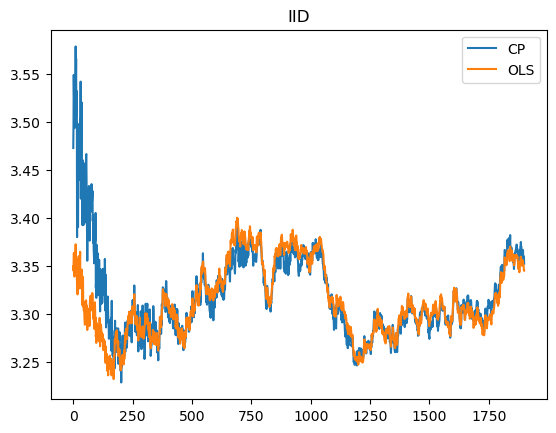

In [97]:
plt.plot(np.array([cp_res[i]['res'][:,4] for i in range(N)]).mean(axis=0), label='CP')
plt.plot(np.array([ols_res[i]['res'][:,4] for i in range(N)]).mean(axis=0), label='OLS')
plt.legend()
plt.title('IID')

In [98]:
iid_cp_res = deepcopy(cp_res)
iid_ols_res = deepcopy(ols_res)

## Test 2: Change points

In [99]:
# Target error rate and step size
epsilon = 0.1
gamma = 0.005

cp_res = {}
ols_res = {}

for seed in tqdm(range(N), desc='Running experiment', total=N):
    rnd_gen = np.random.default_rng(seed)

    # Generate data
    X = rnd_gen.normal(loc=0, scale=1, size=(2000, 4))
    beta1 = np.array([2, 1, 0, 0])
    beta2 = np.array([0, -2,-1, 0])
    beta3 = np.array([0, 0, 2, 1])

    Y1 = X[:500] @ beta1 + rnd_gen.normal(loc=0, scale=1, size=500)
    Y2 = X[500:1500] @ beta2 + rnd_gen.normal(loc=0, scale=1, size=1000)
    Y3 = X[1500:] @ beta3 + rnd_gen.normal(loc=0, scale=1, size=500)
    Y = np.concatenate([Y1, Y2, Y3])

    # Split data
    initial_training_size = 100
    X_train = X[:initial_training_size]
    y_train = Y[:initial_training_size]

    X_run = X[initial_training_size:]
    y_run = Y[initial_training_size:]

    # Run full CP

    from CRR import ConformalRidgeRegressor
    cp = ConformalRidgeRegressor(a=0)

    time_init_cp = time.time()
    cp.learn_initial_training_set(X_train, y_train)

    Err_cp = 0

    eps = epsilon

    predictions_cp = np.empty((X_run.shape[0], 5))
    for i, (obj, label) in enumerate(zip(X_run, y_run)):
        # Reality presents the object x
        x = obj
        # Forecaster outputs Gamma
        Gamma, precomputed = cp.predict(x, epsilon=eps, bounds='both', return_update=True)
        width = cp.width(Gamma)
        # Reality presents the label
        y = label
        cp.learn_one(x, y, precomputed)
        err = cp.err(Gamma, label)

        eps += gamma*(epsilon - err)
        eps = max(2/cp.X.shape[0], eps)

        Err_cp += err
        predictions_cp[i, 0] = Gamma[0] # Lower 
        predictions_cp[i, 1] = Gamma[1] # Upper 
        predictions_cp[i, 2] = err # Error
        predictions_cp[i, 3] = eps # True label
        predictions_cp[i, 4] = width # True label
    time_cp = time.time() - time_init_cp

    cp_res[seed] = {'time': time_cp, 'res': predictions_cp}


    # Run OLS

    from Ridge_point_predictor import OnlineRidgeRegressor

    ols = OnlineRidgeRegressor(a=0)

    time_init_ols = time.time()

    ols.learn_initial_training_set(X_train, y_train)

    Err_ols = 0

    eps = epsilon

    predictions_ols = np.empty((X_run.shape[0], 5))
    for i, (obj, label) in enumerate(zip(X_run, y_run)):
        # Reality presents the object x
        x = obj
        Gamma = ols.predict_interval(x, epsilon=eps)
        width = ols.width(Gamma)
        # Reality reveals y
        y = label
        ols.learn_one(x, y)
        err = ols.err(Gamma, label)

        eps += gamma*(epsilon - err)
        eps = max(2/ols.X.shape[0], eps)

        Err_ols += err
        predictions_ols[i, 0] = Gamma[0] # Lower 
        predictions_ols[i, 1] = Gamma[1] # Upper 
        predictions_ols[i, 2] = err # Error
        predictions_ols[i, 3] = eps # True label
        predictions_ols[i, 4] = width # True label
    time_ols = time.time() - time_init_ols

    ols_res[seed] = {'time': time_ols, 'res': predictions_ols}

Running experiment:   0%|          | 0/20 [00:00<?, ?it/s]

In [100]:
# Mean error cp
sum([cp_res[i]['res'][:,2].sum() for i in range(N)]) / (N*y_run.shape[0])

0.10526315789473684

In [101]:
# Mean error ols
sum([ols_res[i]['res'][:,2].sum() for i in range(N)]) / (N*y_run.shape[0])

0.11021052631578947

In [102]:
# Mean width cp
sum([cp_res[i]['res'][:,4].sum() for i in range(N)]) / (N*y_run.shape[0])

7.234555183644337

In [103]:
# Mean width ols
sum([ols_res[i]['res'][:,4].sum() for i in range(N)]) / (N*y_run.shape[0])

7.074104164619598

In [104]:
# Mean time cp
np.mean([cp_res[i]['time'] for i in range(N)])

30.56385979652405

In [105]:
# Mean time ols
np.mean([ols_res[i]['time'] for i in range(N)])

0.578895115852356

Text(0.5, 1.0, 'Change points')

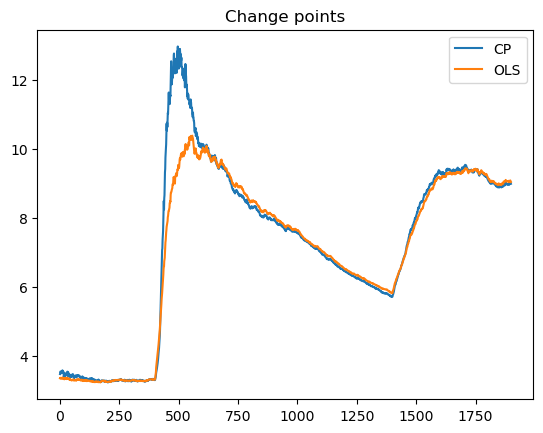

In [106]:
plt.plot(np.array([cp_res[i]['res'][:,4] for i in range(N)]).mean(axis=0), label='CP')
plt.plot(np.array([ols_res[i]['res'][:,4] for i in range(N)]).mean(axis=0), label='OLS')
plt.legend()
plt.title('Change points')

In [107]:
change_point_cp_res = deepcopy(cp_res)
change_point_ols_res = deepcopy(ols_res)

## Test 3: Drift (mean)

In [108]:
# Target error rate and step size
epsilon = 0.1
gamma = 0.005

cp_res = {}
ols_res = {}

for seed in tqdm(range(N), desc='Running experiment', total=N):
    rnd_gen = np.random.default_rng(seed)

    # Generate data
    X = rnd_gen.normal(loc=0, scale=1, size=(2000, 4))
    beta1 = np.array([2, 1, 0, 0])
    betaN = np.array([0, 0, 2, 1])
    Y = np.zeros((X.shape[0]))
    for i, x in enumerate(X):
        Y[i] = x @ ((1 - i/(X.shape[0]-1))*beta1 + (i/(X.shape[0]-1))*betaN) + rnd_gen.normal(loc=0, scale=1)

    # Split data
    initial_training_size = 100
    X_train = X[:initial_training_size]
    y_train = Y[:initial_training_size]

    X_run = X[initial_training_size:]
    y_run = Y[initial_training_size:]

    # Guarantee of ACI is absolute deviation of error rate <= bound
    bound = (max(epsilon, 1-epsilon) + gamma) / (gamma * y_run.shape[0])

    # Run full CP

    from CRR import ConformalRidgeRegressor
    cp = ConformalRidgeRegressor(a=0)

    time_init_cp = time.time()
    cp.learn_initial_training_set(X_train, y_train)

    Err_cp = 0

    eps = epsilon

    predictions_cp = np.empty((X_run.shape[0], 5))
    for i, (obj, label) in enumerate(zip(X_run, y_run)):
        # Reality presents the object x
        x = obj
        # Forecaster outputs Gamma
        Gamma, precomputed = cp.predict(x, epsilon=eps, bounds='both', return_update=True)
        width = cp.width(Gamma)
        # Reality presents the label
        y = label
        cp.learn_one(x, y, precomputed)
        err = cp.err(Gamma, label)

        eps += gamma*(epsilon - err)
        eps = max(2/cp.X.shape[0], eps)

        Err_cp += err
        predictions_cp[i, 0] = Gamma[0] # Lower 
        predictions_cp[i, 1] = Gamma[1] # Upper 
        predictions_cp[i, 2] = err # Error
        predictions_cp[i, 3] = eps # True label
        predictions_cp[i, 4] = width # True label
    time_cp = time.time() - time_init_cp

    cp_res[seed] = {'time': time_cp, 'res': predictions_cp}


    # Run OLS

    from Ridge_point_predictor import OnlineRidgeRegressor

    ols = OnlineRidgeRegressor(a=0)

    time_init_ols = time.time()

    ols.learn_initial_training_set(X_train, y_train)

    Err_ols = 0

    eps = epsilon

    predictions_ols = np.empty((X_run.shape[0], 5))
    for i, (obj, label) in enumerate(zip(X_run, y_run)):
        # Reality presents the object x
        x = obj
        Gamma = ols.predict_interval(x, epsilon=eps)
        width = ols.width(Gamma)
        # Reality reveals y
        y = label
        ols.learn_one(x, y)
        err = ols.err(Gamma, label)

        eps += gamma*(epsilon - err)
        eps = max(2/ols.X.shape[0], eps)

        Err_ols += err
        predictions_ols[i, 0] = Gamma[0] # Lower 
        predictions_ols[i, 1] = Gamma[1] # Upper 
        predictions_ols[i, 2] = err # Error
        predictions_ols[i, 3] = eps # True label
        predictions_ols[i, 4] = width # True label
    time_ols = time.time() - time_init_ols

    ols_res[seed] = {'time': time_ols, 'res': predictions_ols}

Running experiment:   0%|          | 0/20 [00:00<?, ?it/s]

In [109]:
# Mean error cp
sum([cp_res[i]['res'][:,2].sum() for i in range(N)]) / (N*y_run.shape[0])

0.10736842105263159

In [110]:
# Mean error ols
sum([ols_res[i]['res'][:,2].sum() for i in range(N)]) / (N*y_run.shape[0])

0.10773684210526316

In [111]:
# Mean width cp
sum([cp_res[i]['res'][:,4].sum() for i in range(N)]) / (N*y_run.shape[0])

4.388946342825405

In [112]:
# Mean width ols
sum([ols_res[i]['res'][:,4].sum() for i in range(N)]) / (N*y_run.shape[0])

4.368054188090125

In [113]:
# Mean time cp
np.mean([cp_res[i]['time'] for i in range(N)])

33.42615451812744

In [114]:
# Mean time ols
np.mean([ols_res[i]['time'] for i in range(N)])

0.552030348777771

Text(0.5, 1.0, 'Drift')

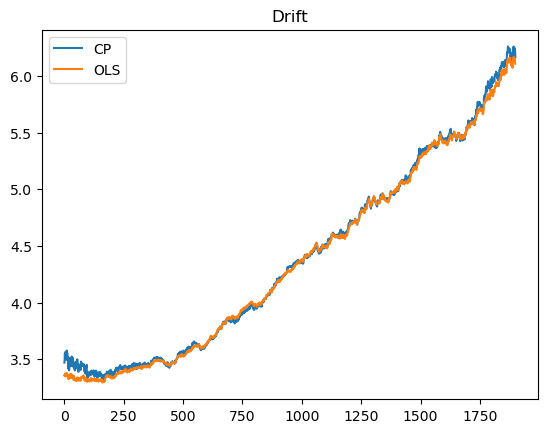

In [115]:
plt.plot(np.array([cp_res[i]['res'][:,4] for i in range(N)]).mean(axis=0), label='CP')
plt.plot(np.array([ols_res[i]['res'][:,4] for i in range(N)]).mean(axis=0), label='OLS')
plt.legend()
plt.title('Drift')

In [116]:
drift_cp_res = deepcopy(cp_res)
drift_ols_res = deepcopy(ols_res)

## Statistics

In [117]:
# Width
cp_iid_mean_width = np.array([iid_cp_res[i]['res'][:,4] for i in range(N)]).mean(axis=1)
ols_iid_mean_width = np.array([iid_ols_res[i]['res'][:,4] for i in range(N)]).mean(axis=1)

cp_change_point_mean_width = np.array([change_point_cp_res[i]['res'][:,4] for i in range(N)]).mean(axis=1)
ols_change_point_mean_width = np.array([change_point_ols_res[i]['res'][:,4] for i in range(N)]).mean(axis=1)

cp_drift_mean_width = np.array([drift_cp_res[i]['res'][:,4] for i in range(N)]).mean(axis=1)
ols_drift_mean_width = np.array([drift_ols_res[i]['res'][:,4] for i in range(N)]).mean(axis=1)

# Absolute deviation
cp_iid_dev = np.abs(np.array([iid_cp_res[i]['res'][:,2] for i in range(N)]).mean(axis=1) - epsilon)
ols_iid_dev = np.abs(np.array([iid_ols_res[i]['res'][:,2] for i in range(N)]).mean(axis=1) - epsilon)

cp_change_point_dev = np.abs(np.array([change_point_cp_res[i]['res'][:,2] for i in range(N)]).mean(axis=1) - epsilon)
ols_change_point_dev = np.abs(np.array([change_point_ols_res[i]['res'][:,2] for i in range(N)]).mean(axis=1) - epsilon)

cp_drift_dev = np.abs(np.array([drift_cp_res[i]['res'][:,2] for i in range(N)]).mean(axis=1) - epsilon)
ols_drift_dev = np.abs(np.array([drift_ols_res[i]['res'][:,2] for i in range(N)]).mean(axis=1) - epsilon)

What do we do about these then...?

In [138]:
# Nice and out of the box, but the p-values can not be combined
from scipy.stats import binomtest

seq = np.array([drift_ols_res[i]['res'][:,2] for i in range(N)])[0]
k = int(seq.sum())
n = int(seq.shape[0])
binomtest(k, n, epsilon)

BinomTestResult(k=207, n=1900, alternative='two-sided', statistic=0.10894736842105263, pvalue=0.1935393313172712)

Let's compute confidence intervals using Ramdas' method. The variance should be fairly low, so they should be tight. We should expect to need about 1000 runs, which takes approximately one day to run. 

But before we run it, let's ensure that we save the data in some good way.